In [1]:
import pandas as pd
from transformers import PreTrainedTokenizerFast
import pysam
from tqdm import tqdm

In [2]:
workdir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/fasta/'

In [3]:
transformer_tokenizer = PreTrainedTokenizerFast(tokenizer_file="../DNABERT2/tokenizer.json",
mask_token = '[MASK]', pad_token = '[PAD]', sep_token = '[SEP]', cls_token = '[CLS]', unk_token = '[UNK]',)

transformer_tokenizer.add_tokens(["NNNNNN"])

1

In [4]:
len(transformer_tokenizer.vocab)

4097

In [4]:
#transformer_tokenizer = PreTrainedTokenizerFast.from_pretrained('./multispecies_tokenizer')

In [ ]:
for word in transformer_tokenizer.vocab:
    if 'N' in word:
        print(word)


In [5]:
chunk_len = 6000
overlap_bp = 0
max_seq_len = 10000

In [7]:
fa = workdir + '241_mammals.shuffled.fa'

seq_names = pd.read_csv(fa + '.fai', sep='\t', header=None, usecols=[0])[0].squeeze().values

fasta = pysam.FastaFile(fa)

data = []

def seq_generator():
    for seq_name in seq_names:
        seq = fasta.fetch(seq_name).upper().replace('-','')[:max_seq_len]
        for start_idx in range(0,len(seq),chunk_len-overlap_bp):
            chunk = seq[start_idx:start_idx+chunk_len]
            if len(chunk)<6:
                continue
            tok = transformer_tokenizer(chunk,
                                            add_special_tokens=True,)
            yield seq_name,seq,tok['input_ids']

last_seq_name = ''
pbar = tqdm(total=len(seq_names))

for seq_name,seq,tokenized_seq in seq_generator():
    data.append((seq_name,len(seq),len(tokenized_seq)))
    if seq_name!=last_seq_name:
        last_seq_name = seq_name
        pbar.update(1)

KeyboardInterrupt: 

In [8]:
len_df = pd.DataFrame(data,columns=['seq_name','seq_len','tok_len'])

len_df.tok_len.max()

1306

In [10]:
len_df[len_df.tok_len==1024].seq_len.mean()

5193.625

Text(10, 1094.84, '1084')

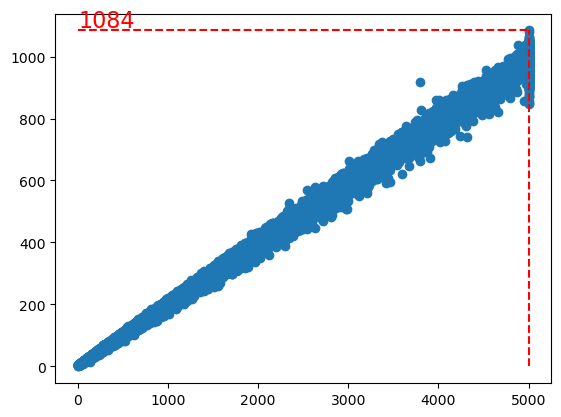

  2%|▏         | 91627/3783714 [01:20<42:58, 1431.82it/s]

In [11]:
seq_chunk_size = 5000
min_bpe_len = len_df[len_df.seq_len<=seq_chunk_size].tok_len.max()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.scatter(len_df.seq_len, len_df.tok_len)

#ax.set_xlim([0,1500])
#ax.set_ylim([0,300])

plt.vlines(x=seq_chunk_size,ymin=0,ymax=min_bpe_len, color='r', linestyle='--')
plt.hlines(y=min_bpe_len,xmin=0,xmax=seq_chunk_size, color='r', linestyle='--')
plt.text(10,min_bpe_len*1.01,min_bpe_len, fontsize=16, color='r')